In [24]:
import re

import pandas as pd
import numpy as np

import seaborn as sns

%matplotlib inline

In [6]:
train_df = pd.read_csv('data/train.csv')
train_df.shape

(159571, 8)

In [7]:
test_df = pd.read_csv('data/test.csv')
test_df.shape

(153164, 2)

In [8]:
labels_df = pd.read_csv('data/test_labels.csv')
labels_df.shape

(153164, 7)

In [9]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [10]:
labels_df.groupby('toxic')['id'].count()

toxic
-1    89186
 0    57888
 1     6090
Name: id, dtype: int64

In [11]:
labels_df[labels_df['toxic'] > -1].count()

id               63978
toxic            63978
severe_toxic     63978
obscene          63978
threat           63978
insult           63978
identity_hate    63978
dtype: int64

For this project, I'll throw out the unlabeled examples (-1), and combine the train and remaining test examples. Then I'll analyze the full dataset before splitting again 80/20.

In [12]:
labeled_test_df = test_df.merge(labels_df, on='id', how='inner')
labeled_test_df = labeled_test_df[labeled_test_df['toxic'] > -1]

full_df = pd.concat([train_df, labeled_test_df], axis=0).reset_index(drop=True)
full_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


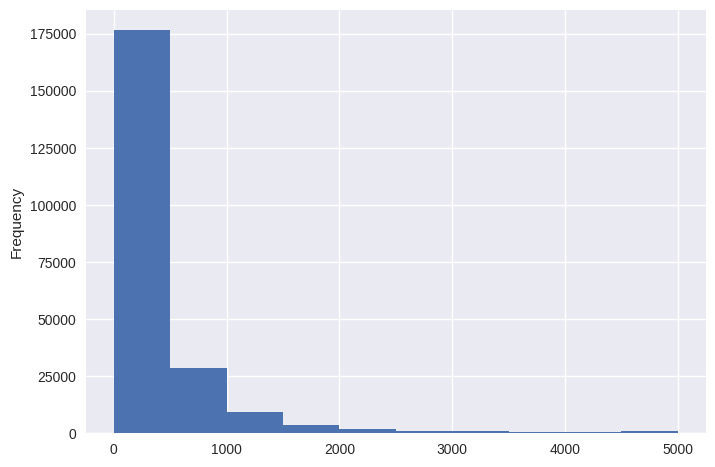

In [13]:
lens = full_df['comment_text'].str.len()
lens.plot(kind='hist');

In [14]:
(lens > 1000).mean()

0.08221911079897472

In [15]:
full_df.groupby('toxic')['id'].count()

toxic
0    202165
1     21384
Name: id, dtype: int64

In [16]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat',
          'insult', 'identity_hate']
full_df['all'] = full_df.apply(lambda x: sum([x[l] for l in labels]), axis=1)

In [17]:
tmp = full_df.groupby('all')['id'].count()
tmp / tmp.sum()

all
0    0.899494
1    0.036690
2    0.022411
3    0.028137
4    0.010606
5    0.002460
6    0.000201
Name: id, dtype: float64

In [18]:
full_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,all
count,223549.000000,223549.000000,223549.000000,223549.000000,223549.000000,223549.000000,223549.000000
mean,0.095657,0.008777,0.054306,0.003082,0.050566,0.009470,0.221857
std,0.294121,0.093272,0.226621,0.055431,0.219110,0.096852,0.754190
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000


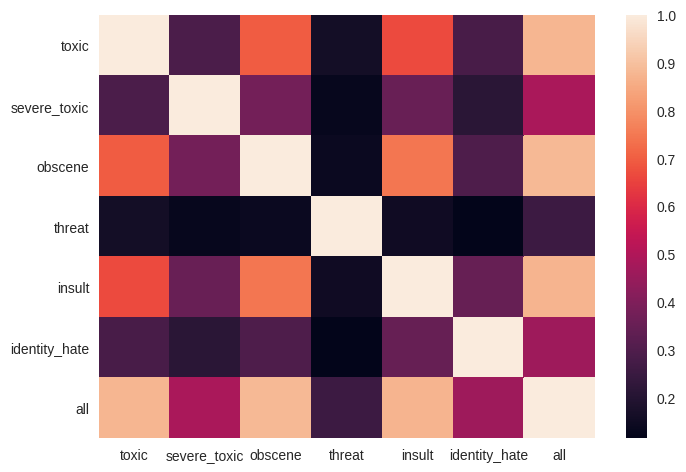

In [19]:
def histogram_intersection(a, b):
    v = np.minimum(a, b).sum().round(decimals=1)
    return v

sns.heatmap(full_df.corr(method='pearson'))

## Is amount of punctuation correlated with any labels?

In [23]:
full_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,all
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [ ]:
full_df

In [ ]:
full_df['comment_text']